### Installing Detectron2

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-17z0fzv2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-17z0fzv2
  Resolved https://github.com/facebookresearch/detectron2.git to commit b1c43ffbc995426a9a6b5c667730091a384e0fa4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.8 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

### Importing Libraries

In [ ]:
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.logger import setup_logger
setup_logger()

import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Lung_Segmentation/DetectronCompatibleData.zip

Streaming output truncated to the last 5000 lines.
  inflating: DetectronCompatibleData/train/VESSEL12_09_245.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_246.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_247.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_248.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_249.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_25.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_250.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_251.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_252.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_253.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_254.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_255.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_256.jpg  
  inflating: DetectronCompatibleData/train/VESSEL12_09_257.jpg  
  inflating: DetectronCompatibleData/tra

### Registering the dataset

In [ ]:
register_coco_instances("my_dataset_train", {}, "/content/DetectronCompatibleData/train/coco_train_dataset.json", "/content/DetectronCompatibleData/train")
register_coco_instances("my_dataset_val", {}, "/content/DetectronCompatibleData/val/coco_val_dataset.json", "/content/DetectronCompatibleData/val")
register_coco_instances("my_dataset_test", {}, "/content/DetectronCompatibleData/test/coco_test_dataset.json", "/content/DetectronCompatibleData/test")

### Visualisation of Data

[01/03 04:04:58 d2.data.datasets.coco]: Loading /content/DetectronCompatibleData/train/coco_train_dataset.json takes 1.29 seconds.
[01/03 04:04:58 d2.data.datasets.coco]: Loaded 6954 images in COCO format from /content/DetectronCompatibleData/train/coco_train_dataset.json


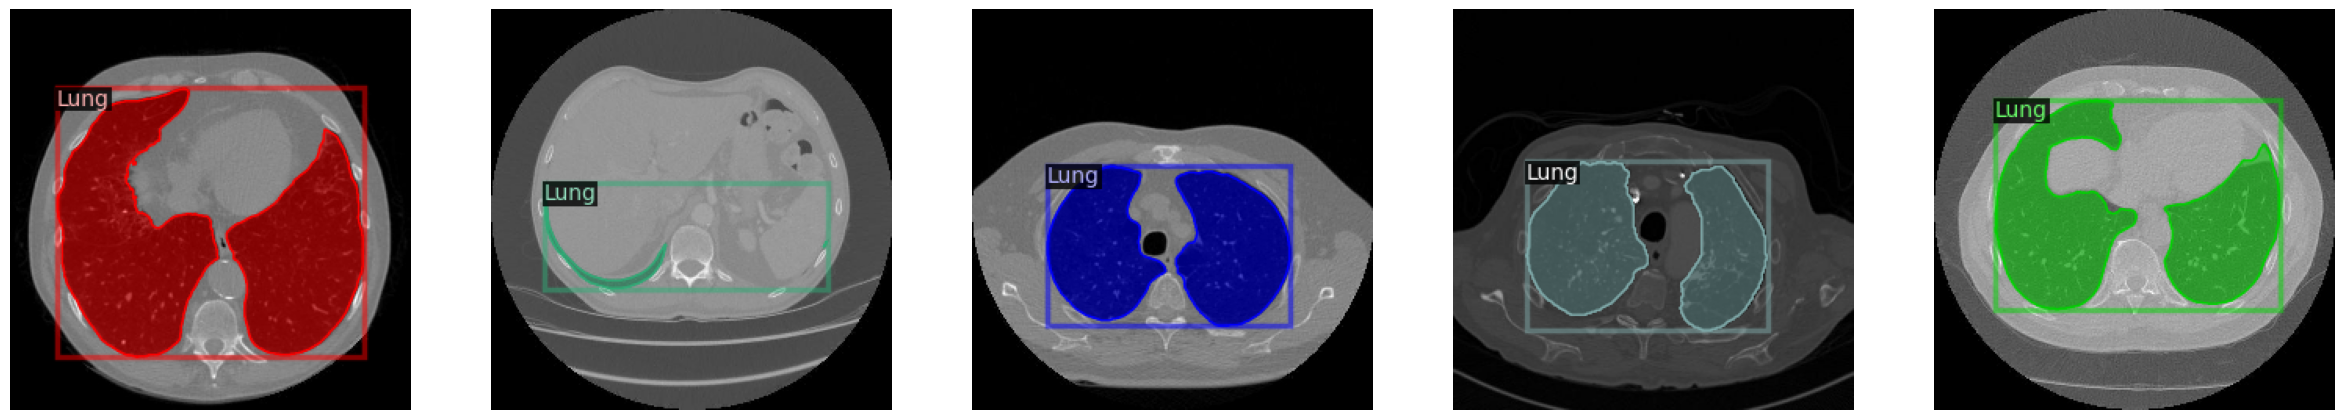

In [ ]:

my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

fig, axs = plt.subplots(1, 5, figsize=(30, 10))
for ax, d in zip(axs, random.sample(dataset_dicts, 5)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    img_rgb = vis.get_image()[:, :, ::-1]

    ax.imshow(img_rgb)
    ax.axis('off')

plt.show()

### Model Loading, setting up configurations and Training

In [ ]:
# Read https://github.com/facebookresearch/detectron2/blob/main/detectron2/config/defaults.py before setting configs
cfg = get_cfg()


cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

cfg.DATALOADER.NUM_WORKERS = 2

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.INPUT.MASK_FORMAT='bitmask'
cfg.INPUT.MIN_SIZE_TRAIN = (512,)
cfg.INPUT.MAX_SIZE_TRAIN = 512
cfg.INPUT.MIN_SIZE_TEST = 512
cfg.INPUT.MAX_SIZE_TEST = 512
cfg.INPUT.RANDOM_FLIP="none"

cfg.MODEL.DEVICE = "cuda"
cfg.MODEL.BACKBONE.FREEZE_AT=2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.AMP.ENABLED = True
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.IMS_PER_BATCH =4

# cfg.TEST.EVAL_PERIOD = 50



cfg.OUTPUT_DIR = "./Segmentation_output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
from detectron2.config import CfgNode
from detectron2.solver.build import get_default_optimizer_params, maybe_add_gradient_clipping
import torch

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_optimizer(cls, cfg: CfgNode, model: torch.nn.Module) -> torch.optim.Optimizer:
        """
        Build an optimizer from config.
        """
        params = get_default_optimizer_params(
            model,
            base_lr=cfg.SOLVER.BASE_LR,
            weight_decay_norm=cfg.SOLVER.WEIGHT_DECAY_NORM,
            bias_lr_factor=cfg.SOLVER.BIAS_LR_FACTOR,
            weight_decay_bias=cfg.SOLVER.WEIGHT_DECAY_BIAS,
        )
        return maybe_add_gradient_clipping(cfg, torch.optim.Adam)(
            params,
            lr=cfg.SOLVER.BASE_LR,
            weight_decay=cfg.SOLVER.WEIGHT_DECAY,
        )

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="detectron2.engine.train_loop")

In [ ]:
# trainer = DefaultTrainer(cfg)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.model.to("cuda")
trainer.train()

[01/03 04:05:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:01, 152MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/03 04:05:05 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/detectron2/data/detection_utils.py:449: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/usr/local/lib/python3.10/dist-packages/detectron2/data/detection_utils.py:449: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Tri

[01/03 04:05:15 d2.utils.events]:  eta: 0:13:49  iter: 19  total_loss: 1.79  loss_cls: 0.6534  loss_box_reg: 0.4112  loss_mask: 0.693  loss_rpn_cls: 0.01473  loss_rpn_loc: 0.005688    time: 0.2692  last_time: 0.2417  data_time: 0.0397  last_data_time: 0.0223   lr: 1.9981e-06  max_mem: 1952M
[01/03 04:05:23 d2.utils.events]:  eta: 0:11:45  iter: 39  total_loss: 1.528  loss_cls: 0.3779  loss_box_reg: 0.4002  loss_mask: 0.6924  loss_rpn_cls: 0.006624  loss_rpn_loc: 0.00551    time: 0.2533  last_time: 0.2348  data_time: 0.0219  last_data_time: 0.0195   lr: 3.9961e-06  max_mem: 1970M
[01/03 04:05:29 d2.utils.events]:  eta: 0:12:07  iter: 59  total_loss: 1.315  loss_cls: 0.1723  loss_box_reg: 0.3932  loss_mask: 0.6905  loss_rpn_cls: 0.007858  loss_rpn_loc: 0.006258    time: 0.2708  last_time: 0.2437  data_time: 0.0385  last_data_time: 0.0418   lr: 5.9941e-06  max_mem: 1970M
[01/03 04:05:34 d2.utils.events]:  eta: 0:11:37  iter: 79  total_loss: 1.209  loss_cls: 0.1192  loss_box_reg: 0.4035  l

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./Segmentation_output

### Inference and Evaluaton

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)

[01/03 04:18:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./Segmentation_output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[01/03 04:18:19 d2.data.datasets.coco]: Loaded 802 images in COCO format from /content/DetectronCompatibleData/test/coco_test_dataset.json


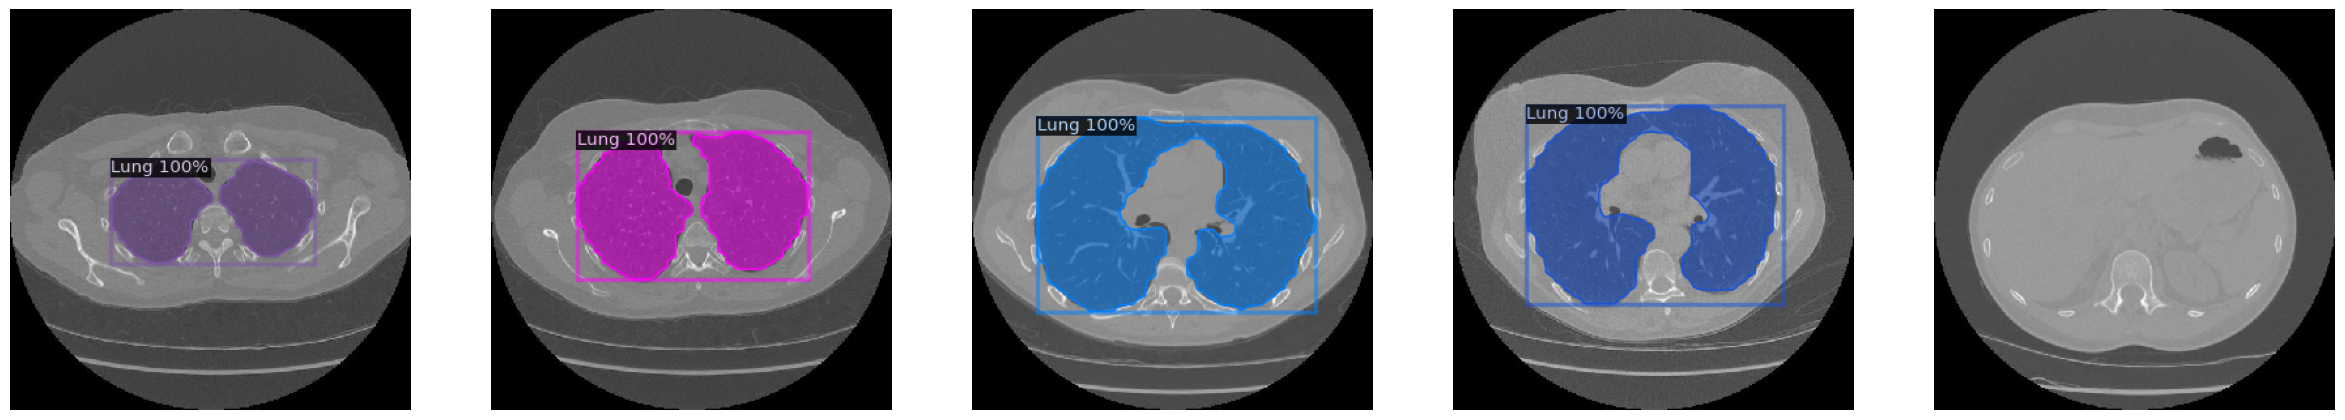

In [ ]:
dataset_dicts = DatasetCatalog.get("my_dataset_test")

fig, axs = plt.subplots(1, 5, figsize=(30, 10))

for ax, d in zip(axs, random.sample(dataset_dicts, 5)):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata,
                   scale=0.6
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    img_rgb = v.get_image()[:, :, ::-1]

    ax.imshow(img_rgb)
    ax.axis('off')

plt.show()

Evaluating on Validation Dataset

In [ ]:
val_evaluator = COCOEvaluator("my_dataset_val", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(trainer.model, val_loader, val_evaluator))

[01/03 04:18:21 d2.data.datasets.coco]: Loaded 837 images in COCO format from /content/DetectronCompatibleData/val/coco_val_dataset.json
[01/03 04:18:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(512, 512), max_size=512, sample_style='choice')]
[01/03 04:18:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/03 04:18:21 d2.data.common]: Serializing 837 elements to byte tensors and concatenating them all ...
[01/03 04:18:21 d2.data.common]: Serialized dataset takes 0.91 MiB
[01/03 04:18:21 d2.evaluation.evaluator]: Start inference on 837 batches
[01/03 04:18:22 d2.evaluation.evaluator]: Inference done 11/837. Dataloading: 0.0097 s/iter. Inference: 0.0635 s/iter. Eval: 0.0074 s/iter. Total: 0.0805 s/iter. ETA=0:01:06
[01/03 04:18:27 d2.evaluation.evaluator]: Inference done 82/837. Dataloading: 0.0079 s/iter. Inference: 0.0589 s/iter. Eval: 0.0045 s/iter. Total: 0

Evaluating on Test Dataset

In [ ]:
test_evaluator = COCOEvaluator("my_dataset_test", output_dir= "./output")
test_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, test_loader, test_evaluator))

[01/03 04:19:16 d2.data.datasets.coco]: Loaded 802 images in COCO format from /content/DetectronCompatibleData/test/coco_test_dataset.json
[01/03 04:19:16 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    Lung    | 802          |
|            |              |
[01/03 04:19:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(512, 512), max_size=512, sample_style='choice')]
[01/03 04:19:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/03 04:19:16 d2.data.common]: Serializing 802 elements to byte tensors and concatenating them all ...
[01/03 04:19:16 d2.data.common]: Serialized dataset takes 0.89 MiB
[01/03 04:19:16 d2.evaluation.evaluator]: Start inference on 802 batches
[01/03 04:19:17 d2.evaluation.evaluator]: Inference done 22/802. Dataloading: 0.0011 s/iter. Inference: 0.0522 s/iter.

In [ ]:
os.environ["LC_ALL"] = "C.UTF-8"
os.environ["LANG"] = "C.UTF-8"

import shutil
import os

source_folder = "./Segmentation_output"
destination_folder = "/content/drive/MyDrive/LungSegmentationOutput"

os.makedirs(destination_folder, exist_ok=True)

shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

print(f"Folder successfully copied to {destination_folder}")


Folder successfully copied to /content/drive/MyDrive/LungSegmentationOutput
